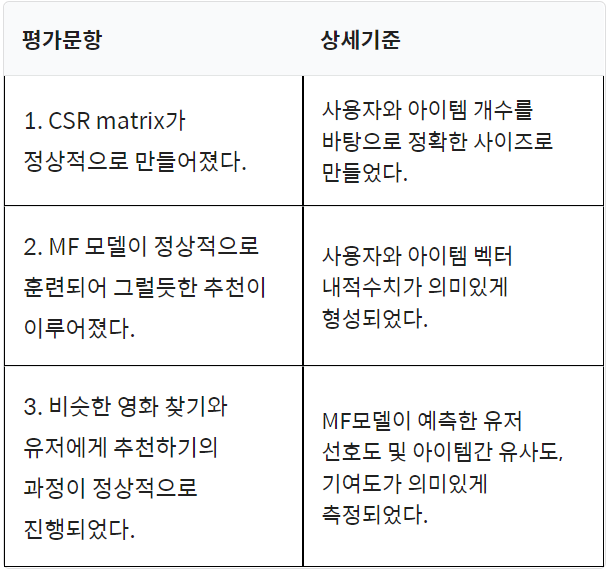

# 1) 데이터 준비와 전처리

In [1]:
import pandas as pd
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [4]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


이후에는 이전 스텝에 소개했던 것과 동일한 방식으로 MF model을 구성하여 내가 좋아할 만한 영화를 추천해 볼 수 있습니다.

# 2) 분석해 봅시다.

ratings에 있는 유니크한 영화 개수   
ratings에 있는 유니크한 사용자 수   
가장 인기 있는 영화 30개(인기순)

In [6]:
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [7]:
ratings

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


#### 두 데이터 movies와 rating을 합친다.

In [8]:
data = pd.merge(ratings, movies)

In [9]:
data

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836473,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,958346883,Slaughterhouse (1987),Horror
836475,5854,690,3,957744257,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,957273353,"Five Wives, Three Secretaries and Me (1998)",Documentary


In [10]:
# 사용하는 컬럼만 남겨준다.
using_cols = ['user_id', 'counts', 'title']
data = data[using_cols]
data.head(30)

,user_id,counts,title
0,1,5,One Flew Over the Cuckoo's Nest (1975)
1,2,5,One Flew Over the Cuckoo's Nest (1975)
2,12,4,One Flew Over the Cuckoo's Nest (1975)
3,15,4,One Flew Over the Cuckoo's Nest (1975)
4,17,5,One Flew Over the Cuckoo's Nest (1975)
5,18,4,One Flew Over the Cuckoo's Nest (1975)
6,19,5,One Flew Over the Cuckoo's Nest (1975)
7,24,5,One Flew Over the Cuckoo's Nest (1975)
8,28,3,One Flew Over the Cuckoo's Nest (1975)
9,33,5,One Flew Over the Cuckoo's Nest (1975)


In [11]:
# 유저 수
data['user_id'].nunique()

6039

In [12]:
# Movies 수
data['title'].nunique()

3628

In [13]:
# 인기 많은 Movie
artist_count = data.groupby('title')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [14]:
# 유저별 몇 편의 Movie를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['title'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: title, dtype: float64

In [15]:
# 내 개인 취향의 Movies
my_favorite = ['Back to the Future (1985)' , 'Godfather, The (1972)',
               'Forrest Gump (1994)' ,'Saving Private Ryan (1998)','Toy Story (1995)']

# 'kimdong'이라는 user_id가 위 Movies를 5회씩 감상했다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['kimdong']*5, 'title': my_favorite, 'counts':[5]*5})

if not data.isin({'user_id':['kimdong']})['user_id'].any():  # user_id에 'kimdong'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,counts,title
836473,5851,5,One Little Indian (1973)
836474,5854,4,Slaughterhouse (1987)
836475,5854,3,"Promise, The (Versprechen, Das) (1994)"
836476,5938,4,"Five Wives, Three Secretaries and Me (1998)"
836477,5948,5,Identification of a Woman (Identificazione di ...
0,kimdong,5,Back to the Future (1985)
1,kimdong,5,"Godfather, The (1972)"
2,kimdong,5,Forrest Gump (1994)
3,kimdong,5,Saving Private Ryan (1998)
4,kimdong,5,Toy Story (1995)


## 데이터 전처리

 ### indexing

In [16]:
# 고유한 유저, movies를 찾아내는 코드
user_unique = data['user_id'].unique()
movies_unique = data['title'].unique()

# 유저, movies indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movies_to_idx = {v:k for k,v in enumerate(movies_unique)}

# 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

In [17]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['kimdong'])    # 6040명의 유저 중 마지막으로 추가된 유저이니 6039이 나와야 합니다. 
print(movies_to_idx['Back to the Future (1985)'])

6039
22


In [18]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movies_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movies_data = data['title'].map(movies_to_idx.get).dropna()
if len(temp_movies_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_movies_data
else:
    print('title column indexing Fail!!')

data

user_id column indexing OK!!
title column indexing OK!!


,user_id,counts,title
0,0,5,0
1,1,5,0
2,2,4,0
3,3,4,0
4,4,5,0
...,...,...,...
0,6039,5,22
1,6039,5,607
2,6039,5,160
3,6039,5,48


# 4) CSR matrix를 직접 만들어 봅시다.

In [19]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [20]:
# 블필요한 columns은 삭제한다.
using_cols = ['user_id', 'counts', 'title']
data = data[using_cols]
data.head(10)

,user_id,counts,title
0,0,5,0
1,1,5,0
2,2,4,0
3,3,4,0
4,4,5,0
5,5,4,0
6,6,5,0
7,7,5,0
8,8,3,0
9,9,5,0


In [21]:
num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()

csr_data = csr_matrix((data.counts, (data.user_id, data.title)), shape = (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

# 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [22]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [23]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100,
                                    regularization=0.01,
                                    use_gpu=False,
                                    iterations=15,
                                    dtype=np.float32)

In [24]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [25]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [29]:
kimdong, Godfather = user_to_idx['kimdong'], movies_to_idx['Godfather, The (1972)']
kimdong_vector, Godfather_vector = als_model.user_factors[kimdong], als_model.item_factors[Godfather]

print('완료')

완료


In [32]:
kimdong_vector

array([ 0.3817467 ,  0.41716573, -0.00329823,  0.36473387,  0.38429582,
       -0.94049454, -0.754663  ,  0.58947486,  1.1748477 , -0.12904777,
       -0.315596  , -0.47725162, -0.2545053 , -0.17986698,  0.351091  ,
        0.41313252, -0.5948246 , -0.9736032 , -0.46887454,  0.8419922 ,
       -0.76405156,  0.46178782, -0.2530516 ,  1.2059768 , -0.22872663,
        0.6163017 ,  0.1300079 ,  0.17287043, -0.22159922,  0.25471935,
       -0.03352465, -0.33557424,  0.10917419, -0.18993506,  0.35500368,
       -0.15525296, -0.4371691 , -0.21930987, -0.07064125, -0.67514527,
        0.5293369 ,  0.2061883 , -0.4916925 ,  0.22458565, -0.38886467,
       -0.56393135,  0.6372636 ,  0.46946648, -0.77586526,  1.0784138 ,
       -0.48341644,  0.15243122, -0.11257567, -0.8667039 , -0.12597777,
       -0.26585633,  0.24874766,  0.31104422,  1.077718  , -0.42175245,
        0.0351328 ,  0.31628552,  0.60088384,  0.54687107, -0.19833198,
       -0.44648597,  0.71340173,  0.70408416, -0.6651556 ,  0.19

In [33]:
Godfather_vector

array([ 1.14935823e-02, -2.20168661e-02,  3.11801536e-03,  2.26605106e-02,
        3.74504402e-02, -1.37263900e-02, -1.98560860e-02,  1.59114432e-02,
        1.99531894e-02,  3.03093046e-02, -2.59670354e-02, -1.08542508e-02,
       -2.16516126e-02,  7.00917514e-03,  3.24535072e-02,  2.78778728e-02,
       -5.38493134e-03, -1.71649717e-02,  3.79191572e-03,  2.40297243e-02,
       -1.11443438e-02, -3.23614553e-02,  4.64174449e-02,  3.69883701e-02,
       -2.58300286e-02,  7.47950375e-03,  1.74986292e-02,  3.88157591e-02,
       -1.48553038e-02,  4.07950990e-02,  5.72292646e-03, -1.74370632e-02,
       -5.43465978e-03, -2.15242971e-02,  2.89992057e-02, -3.95464245e-03,
       -7.86781684e-03, -3.71210324e-03,  3.98237929e-02,  4.13653441e-03,
        4.27489802e-02,  3.26251239e-02, -5.66953467e-03, -1.62064545e-02,
        1.81389917e-02,  7.71116139e-03,  1.25933094e-02,  6.43686019e-03,
       -2.82370821e-02,  3.97824720e-02, -1.17674163e-02, -2.03943383e-02,
        1.11470940e-02, -

### 나의 선호도

In [35]:
# kimdong과 Godfather를 내적하는 코드
np.dot(kimdong_vector, Godfather_vector)

0.65573627

# 7) 비슷한 Movies 찾기

In [39]:
# movies_to_idx 를 뒤집어, index로부터 영화 제목을 얻는 dict를 생성
idx_to_movie = {v:k for k,v in movies_to_idx.items()}

In [42]:
# 비슷한 movies를 찾아주는 함수
def get_similar_movie(movie_title: str):
    movie_id = movies_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [43]:
get_similar_movie('Godfather, The (1972)')

['Godfather, The (1972)',
 'Godfather: Part II, The (1974)',
 'Godfather: Part III, The (1990)',
 'French Connection, The (1971)',
 'Paralyzing Fear: The Story of Polio in America, A (1998)',
 'Citizen Kane (1941)',
 'Condition Red (1995)',
 'Boys, The (1997)',
 'Simon Sez (1999)',
 'GoodFellas (1990)']

# 8) 유저에게 추천하기(내가 좋아하는 영화 찾기)

In [44]:
user = user_to_idx['kimdong']

movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True) 
                                                 # filter_already_liked_items 는 유저가 이미 평가한 아이템은 제외하는 Argument
movie_recommended

[(380, 0.5617347),
 (50, 0.5397959),
 (23, 0.4678654),
 (87, 0.39164704),
 (110, 0.3745981),
 (64, 0.35493016),
 (435, 0.3355711),
 (117, 0.28588068),
 (4, 0.28490037),
 (157, 0.28172398),
 (44, 0.27015203),
 (99, 0.25769758),
 (120, 0.23979892),
 (183, 0.22365142),
 (248, 0.21686295),
 (124, 0.21219826),
 (141, 0.20191857),
 (121, 0.19921155),
 (33, 0.19898191),
 (26, 0.19045907)]

In [45]:
for i in movie_recommended:
    print("{} : {:04.3f}".format(idx_to_movie[i[0]], i[1]))

Godfather: Part II, The (1974) : 0.562
Toy Story 2 (1999) : 0.540
Schindler's List (1993) : 0.468
Braveheart (1995) : 0.392
Groundhog Day (1993) : 0.375
Star Wars: Episode VI - Return of the Jedi (1983) : 0.355
Godfather: Part III, The (1990) : 0.336
Star Wars: Episode V - The Empire Strikes Back (1980) : 0.286
Bug's Life, A (1998) : 0.285
Shawshank Redemption, The (1994) : 0.282
Star Wars: Episode IV - A New Hope (1977) : 0.270
American Beauty (1999) : 0.258
Raiders of the Lost Ark (1981) : 0.240
Butch Cassidy and the Sundance Kid (1969) : 0.224
Good Will Hunting (1997) : 0.217
Matrix, The (1999) : 0.212
Fugitive, The (1993) : 0.202
Silence of the Lambs, The (1991) : 0.199
Aladdin (1992) : 0.199
E.T. the Extra-Terrestrial (1982) : 0.190


In [47]:
gotfather_2 = movies_to_idx['Godfather: Part II, The (1974)']
explain = als_model.explain(user, csr_data, itemid = gotfather_2)

In [48]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Godfather, The (1972)', 0.5716129634890429),
 ('Saving Private Ryan (1998)', 0.040837201137523524),
 ('Toy Story (1995)', -0.01037160891769908),
 ('Back to the Future (1985)', -0.021069268905663206),
 ('Forrest Gump (1994)', -0.028907343653968815)]

# 퇴고

pandas를 활용하여 데이터 구조를 파악하고 새롭게 구성하는 것이 중요성을 깨닫는 Exp였으며 matrix를 활용하여 이러한 추천시스템이 구현되는것이 참으로 신기하고 놀라웠다. 하지만 실제 나에게 추천영화에는 내가 좋아하지 않는 영화가 절반이 넘어서 신뢰성있는 추천시스템을 위해서는 보다 다양한 입력데이터와 분석방식이 도입되어야 겠다.